## In this notebook we will explore our image dataset and apply some ML algorithms/models with scikit-learn to estimate the complexity of the task.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg
from typing import Optional
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from typing import Dict, Any

## An overview of the dataset

In [2]:
DATA_PATH = '../data/img'
PLOT_PATH = './plots'

In [3]:
def display_images(path: str,
                   output: Optional[str] = None) -> None:
    """
    display randomly 3 images from 3 classes.
    @param {str} path - path to the folder containing the classes
    @param {str} output - path to save the image
    """
    
    classes = os.listdir(path)
    classes = random.sample(classes, 3)

    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    for i, class_ in enumerate(classes):
        images = os.listdir(os.path.join(path, class_))
        images = random.sample(images, 3)
        for j, image in enumerate(images):
            img = mpimg.imread(os.path.join(path, class_, image))
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'{class_} - {image}')
    if output:
        plt.savefig(output)
    plt.show()

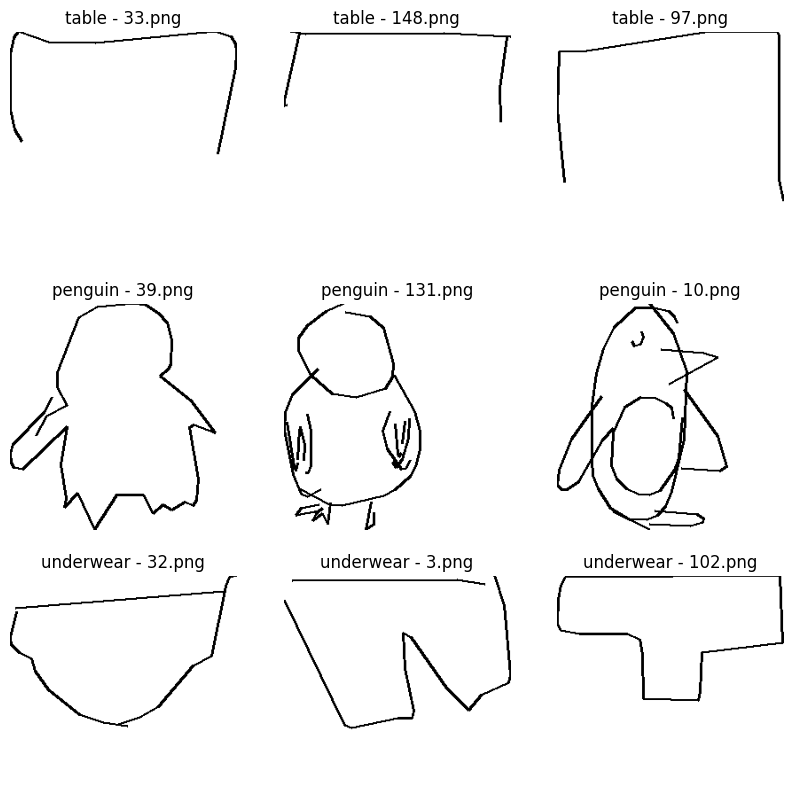

In [4]:
display_images(f"{DATA_PATH}/train")

In [5]:
def plot_images_distribution(path: str,
                             output: Optional[str] = None) -> None:
    """
    plot the distribution of the images in the classes.
    @param {str} path - path to the folder containing the classes
    @param {str} output - path to save the image
    """
    
    classes = os.listdir(path)
    images = [len(os.listdir(os.path.join(path, class_))) for class_ in classes
                if os.path.isdir(os.path.join(path, class_))]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=classes, y=images)
    plt.xticks(rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.title('Images distribution in the classes')
    if output:
        plt.savefig(output)
    plt.show()

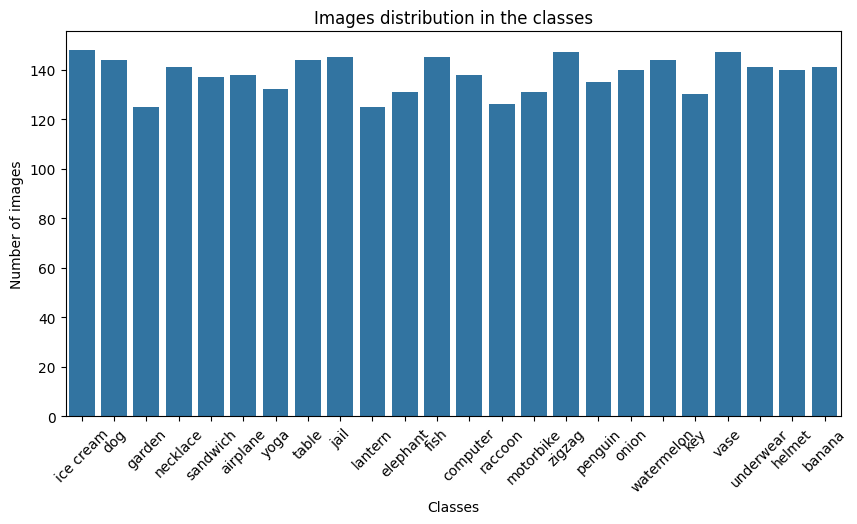

In [6]:
plot_images_distribution(f"{DATA_PATH}/train")

## We therefore have uniformly distributed data, which is ideal for a classification task, the drawings are sometimes not obvious which already gives us a clue as to what type of model to use.

In [7]:
def get_images(path: str) -> dict:
    """
    get the images from the path and convert them to numpy arrays.
    @param {str} path - path to the folder containing the classes
    @return {dict} - dictionary with labels as keys and images as values
    """
    
    images = {}
    classes = os.listdir(path)
    for class_ in tqdm(classes):
        images[class_] = []
        for image in os.listdir(os.path.join(path, class_)):
            img = mpimg.imread(os.path.join(path, class_, image))
            img = np.transpose(img, (2, 0, 1))
            images[class_].append(img)
    return images

In [8]:
train_data = get_images(f"{DATA_PATH}/train")

  0%|          | 0/24 [00:00<?, ?it/s]

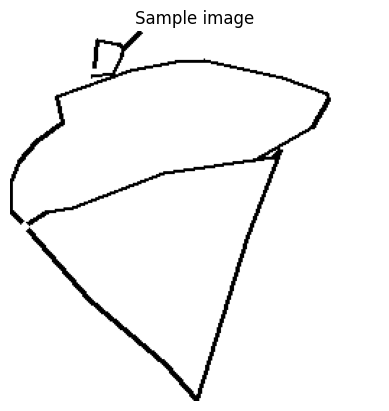

In [9]:
sample = train_data['ice cream'][0]
plt.imshow(sample.transpose(1, 2, 0))
plt.axis('off')
plt.title('Sample image')
plt.show()

In [10]:
train_data['ice cream'][0].shape

(3, 256, 256)

## Unsupervised learning to visualize

In [11]:
def load_train_val_test(path: str,
                        pandas: bool = True) -> dict:
    """
    load the train, validation and test data.
    @param {str} path - path to the folder containing the classes
    @return {dict} - dictionary with train, validation and test data
    """
    
    train = get_images(os.path.join(path, 'train'))
    val = get_images(os.path.join(path, 'val'))
    test = get_images(os.path.join(path, 'test'))

    if pandas:
        train = pd.DataFrame([(np.array(img), label) for label, images in train.items() for img in images],
                             columns=['image', 'label'])
        val = pd.DataFrame([(np.array(img), label) for label, images in val.items() for img in images],
                           columns=['image', 'label'])
        test = pd.DataFrame([(np.array(img), label) for label, images in test.items() for img in images],
                            columns=['image', 'label'])

    return {'train': train, 'val': val, 'test': test}

In [12]:
data_dict = load_train_val_test(DATA_PATH)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [13]:
data_dict['train'].head()

,image,label
0,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream
1,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream
2,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream
3,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream
4,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream


In [14]:
def flatten_images(data: dict) -> dict:
    """
    flatten the images in the data.
    @param {dict} data - dictionary with train, validation and test data
    @return {dict} - dictionary with flattened images
    """
    
    for key in data.keys():
        data[key]['image'] = data[key]['image'].apply(lambda x: np.mean(x, axis=0))
        data[key]['image'] = data[key]['image'].apply(lambda x: x.flatten())
    return data

In [15]:
flattened_data = flatten_images(data_dict)

In [16]:
flattened_data['train'].head()

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream


In [17]:
flattened_data['train'] = flattened_data['train'].sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
flattened_data['train'].head()

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",onion
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",raccoon
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",dog
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",watermelon
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",table


In [19]:
flattened_data['train']['image'].shape

(3315,)

In [20]:
pca = PCA(n_components=3)
X = np.array(flattened_data['train']['image'].tolist())
X_std = StandardScaler().fit_transform(X)
X = pca.fit_transform(X_std)

In [21]:
df_pca = pd.DataFrame(X, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = flattened_data['train']['label']
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='label')
fig.show()

### We cannot distinguish the clusters in 3D, it must be said that there are 24 of them, but the task does not seem to be easy.

In [23]:
kmeans = KMeans(n_clusters=len(flattened_data['train']['label'].unique()), random_state=42)
kmeans.fit(np.array(flattened_data['train']['image'].tolist()))

KMeans(n_clusters=24, random_state=42)

In [24]:
flattened_data['train']

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",onion
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",raccoon
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",dog
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",watermelon
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",table
...,...,...
3310,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",table
3311,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",jail
3312,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",lantern
3313,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",yoga


In [25]:
def plot_cluster_distribution(data: pd.DataFrame,
                             kmeans: KMeans,
                             output: Optional[str] = None) -> pd.DataFrame:
        """
        plot the distribution of the labels in the clusters.
        @param {pd.DataFrame} data - data with the images and labels
        @param {KMeans} kmeans - kmeans model
        @param {str} output - path to save the image
        """
        df = data.copy()
        df['cluster'] = kmeans.labels_
        df = df.groupby(['cluster', 'label']).size().reset_index(name='count')
        
        px.defaults.template = "plotly_dark"
        fig = px.bar(df, x='cluster', y='count', color='label', barmode='relative')
        fig.show()
        if output:
            fig.write_image(output)

        return df
        

In [26]:
df_grped = plot_cluster_distribution(flattened_data['train'], kmeans)

### The K Means algorithm does not seem to be aligned with our classes.

## Training of ML models

In [33]:
flattened_data['train'].head()

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",onion
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",raccoon
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",dog
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",watermelon
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",table


In [36]:
label2idx = {label: idx for idx, label in enumerate(flattened_data['train']['label'].unique())}
idx2label = {idx: label for label, idx in label2idx.items()}
flattened_data['train']['label'] = flattened_data['train']['label'].map(label2idx)

In [38]:
flattened_data['val']['label'] = flattened_data['val']['label'].map(label2idx)
flattened_data['test']['label'] = flattened_data['test']['label'].map(label2idx)

In [39]:
gnb = GaussianNB()

gnb.fit(flattened_data['train']['image'].tolist(), flattened_data['train']['label'])

GaussianNB()

In [47]:
flattened_data['val'].head()

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17


In [62]:
def compute_metrics(data: pd.DataFrame,
                    model: Any) -> Dict[str, float]:
    """
    compute the metrics for the model.
    @param {pd.DataFrame} data - data with the images and labels
    @param {GaussianNB} model - model to evaluate
    @return {Dict[str, float]} - dictionary with the metrics
    """
    
    y_pred = model.predict(data['image'].tolist())
    y_true = data['label']
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

def display_confusion_matrix(data: pd.DataFrame,
                              model: Any,
                              output: Optional[str] = None) -> None:
    """
    display the confusion matrix for the model.
    @param {pd.DataFrame} data - data with the images and labels
    @param {GaussianNB} model - model to evaluate
    @param {str} output - path to save the image
    """
    
    y_pred = model.predict(data['image'].tolist())
    y_true = data['label']
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    if output:
        plt.savefig(output)
    plt.show()

In [42]:
metrics_gnb = compute_metrics(flattened_data['val'], gnb)
print(metrics_gnb)

{'accuracy': 0.1741112123974476, 'precision': 0.28494507008812664, 'recall': 0.1741112123974476, 'f1': 0.1565534604241604}


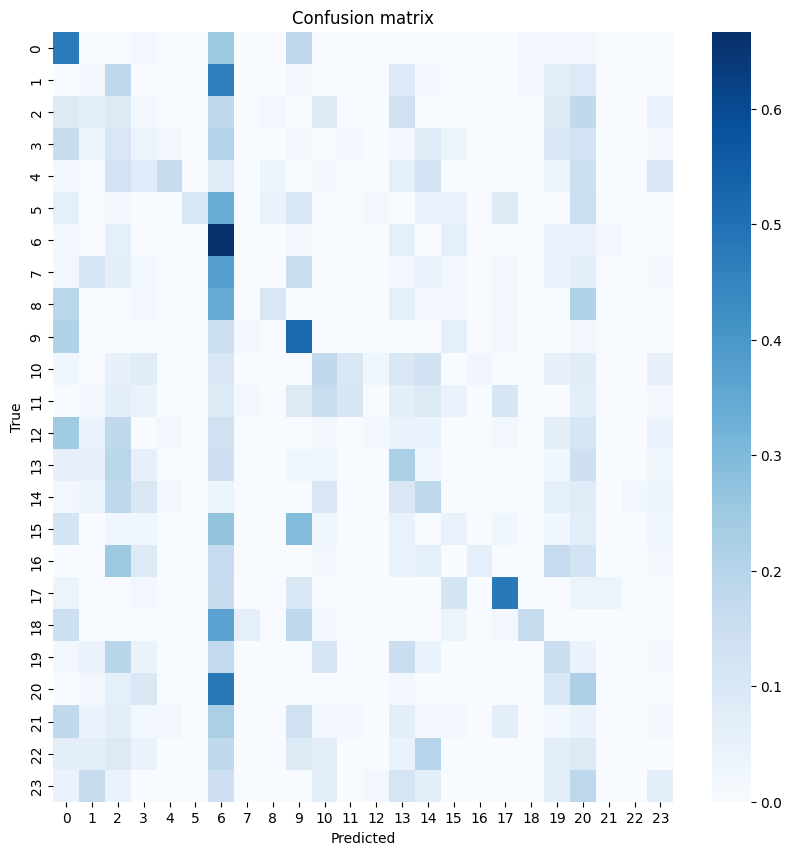

In [63]:
display_confusion_matrix(flattened_data['val'], gnb)

In [55]:
lr = LogisticRegression(max_iter=1000)

lr.fit(flattened_data['train']['image'].tolist(), flattened_data['train']['label'])

LogisticRegression(max_iter=1000)

In [56]:
lr_metrics = compute_metrics(flattened_data['val'], lr)
print(lr_metrics)

{'accuracy': 0.3691886964448496, 'precision': 0.36895010199333156, 'recall': 0.3691886964448496, 'f1': 0.3655333871435031}


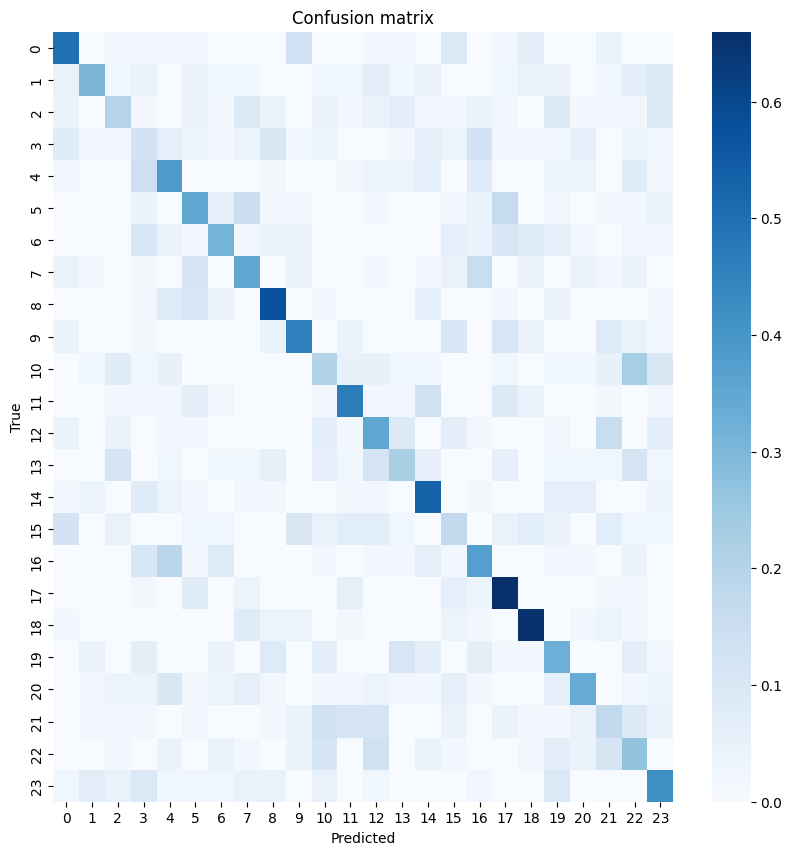

In [64]:
display_confusion_matrix(flattened_data['val'], lr)

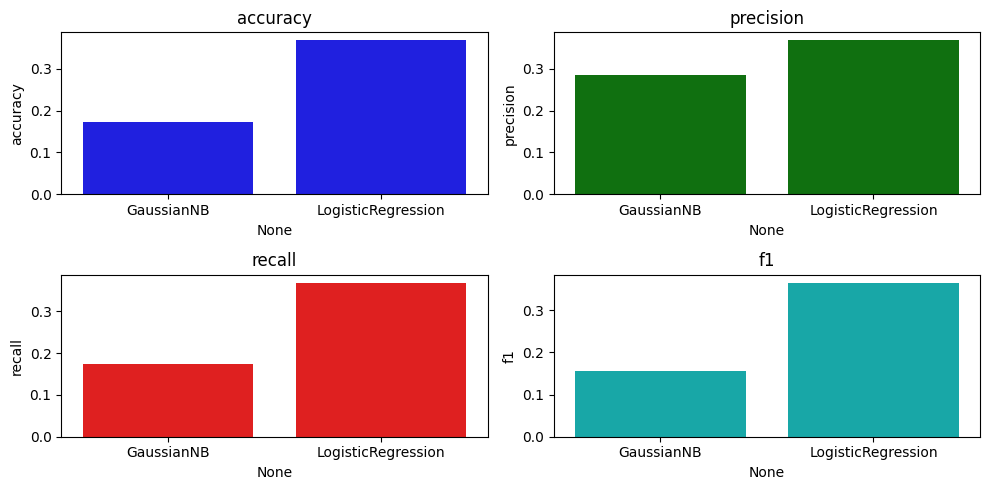

In [61]:
df_metrics = pd.DataFrame([metrics_gnb, lr_metrics], index=['GaussianNB', 'LogisticRegression'])
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
colors = ['b', 'g', 'r', 'c']
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    sns.barplot(x=df_metrics.index, y=df_metrics[metric], ax=axs[i//2, i%2], color=colors[i])
    axs[i//2, i%2].set_title(metric)
plt.tight_layout()
plt.show()

In [68]:
xgb = XGBClassifier()

xgb.fit(flattened_data['train']['image'].tolist(), flattened_data['train']['label'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [70]:
xgb_metrics = compute_metrics(flattened_data['val'], xgb)
print(xgb_metrics)

{'accuracy': 0.28076572470373745, 'precision': 0.28851253938515214, 'recall': 0.28076572470373745, 'f1': 0.267958271378083}


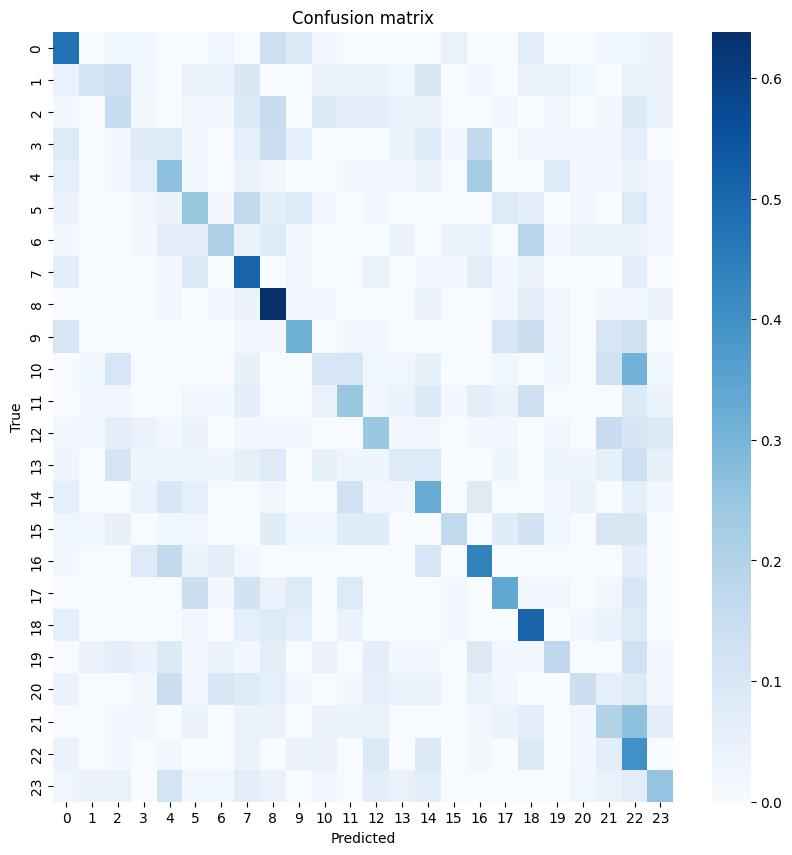

In [72]:
display_confusion_matrix(flattened_data['val'], xgb, f"{PLOT_PATH}/confusion_matrix_xgb.png")

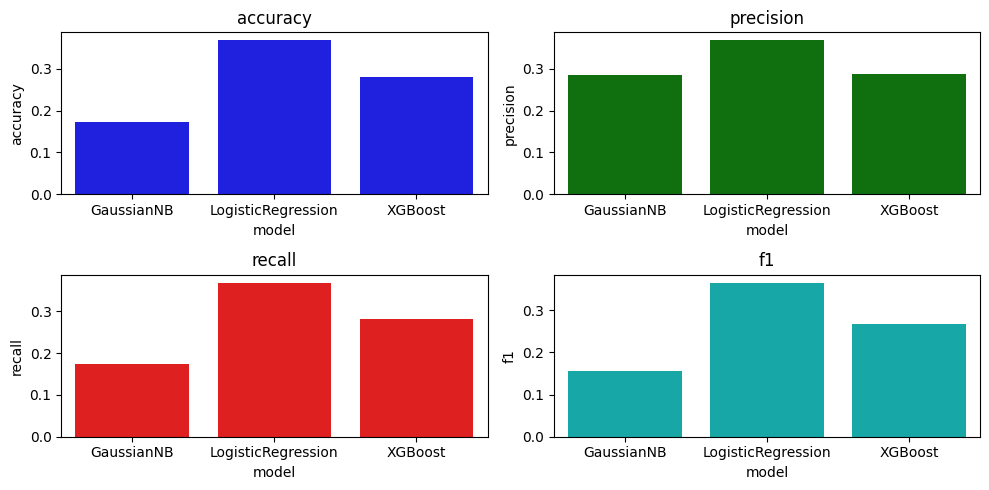

In [80]:
df_metrics = pd.DataFrame([metrics_gnb, lr_metrics, xgb_metrics], index=['GaussianNB', 'LogisticRegression', 'XGBoost'])
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
colors = ['b', 'g', 'r', 'c']
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    sns.barplot(x=df_metrics.index, y=df_metrics[metric], ax=axs[i//2, i%2], color=colors[i])
    axs[i//2, i%2].set_title(metric)
    axs[i//2, i%2].set_xlabel('model')

plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/metrics.png")
plt.show()

## The results of `GaussianNB` are catastrophic, those of `LogisticRegression` and `XGBoost` are a little better due to the fact that we can still distinguish the diagonal, but they still remain bad.